<a href="https://colab.research.google.com/github/RaffyJO/machine-learning-2024/blob/main/ML-Week7-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Raffy Jamil Octavialdy
<br>
Kelas : TI - 3D
<br>
NIM : 2241720082

# **Tugas**

Buatlah sebuah model K-Means dengan ketentuan,
1. Gunakan data 'Mall_Customers.csv'
2. Tentukan fitur apa yang tepat untuk melakukan clustering (minimal 2)
3. Buatlah model K-Means dengan mempertimbangkan jumlah `k` yang terbaik.
4. Buatlah implementasi model SOM untuk segmentasi citra lain

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Mall_Customers.csv')

df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [4]:
df.corr(numeric_only=True)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000


In [5]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [6]:
from sklearn.calibration import LabelEncoder

le = LabelEncoder() # membuat objek dari LabelEncoder
df['Gender'] = le.fit_transform(df['Gender']) # proses encoding

## Menentukan Fitur

Berdasarkan tabel korelasi, didapatkan Annual Income dan Spending Score memiliki nilai korelasi yang cukup, dibanding dengan nilai lainya.

In [12]:
X = df[["Annual Income (k$)","Spending Score (1-100)"]]

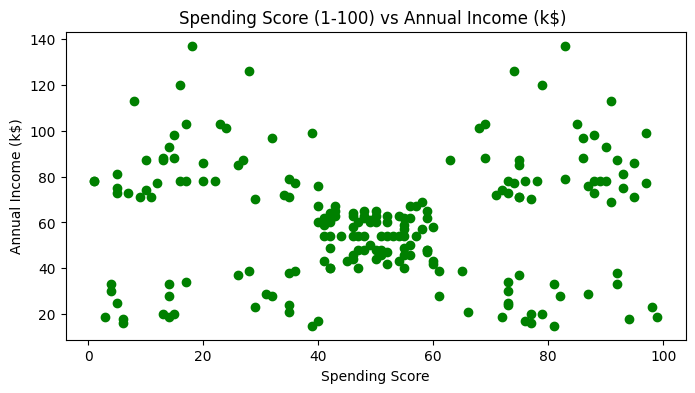

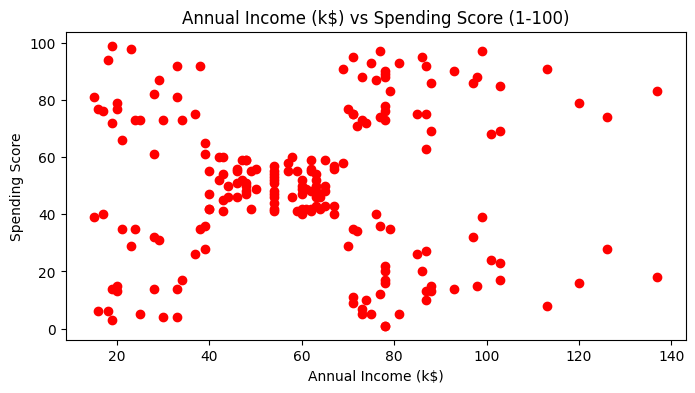

In [13]:
plt.figure(figsize=(8, 4))
plt.scatter(X["Spending Score (1-100)"], X["Annual Income (k$)"], c='g')
plt.title("Spending Score (1-100) vs Annual Income (k$) ")
plt.ylabel("Annual Income (k$)")
plt.xlabel("Spending Score")
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(X["Annual Income (k$)"], X["Spending Score (1-100)"], c='r')
plt.title("Annual Income (k$) vs Spending Score (1-100)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.show()

Dapat dilihat secara kasat mata, terdapat pembentukan cluster pada data tersebut

In [14]:
X.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [15]:
from sklearn.cluster import KMeans

cl_kmeans = KMeans(n_clusters=5)

y_kmeans = cl_kmeans.fit_predict(X)

In [16]:
# Cek Nilai SSE
print(f'Nilai SSE: {cl_kmeans.inertia_}')

Nilai SSE: 44448.45544793369


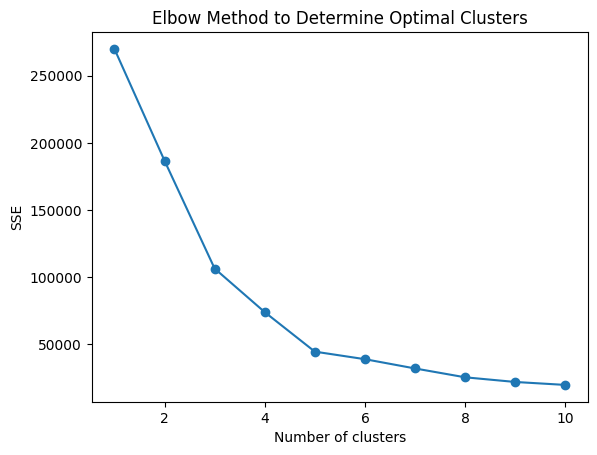

In [24]:
# List nilai SSE
sse = []
for k in range(1,11):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    sse.append(kmeanModel.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

In [31]:
# kluster n=5 ditentukan dari nilai SSE yang menunjukan pelambatan penurunan nilai pada grafik sebelumnya
kmeans = KMeans(n_clusters=5)

kmeans.fit(X)

y_kmeans = kmeans.predict(X)
df["label"] = y_kmeans

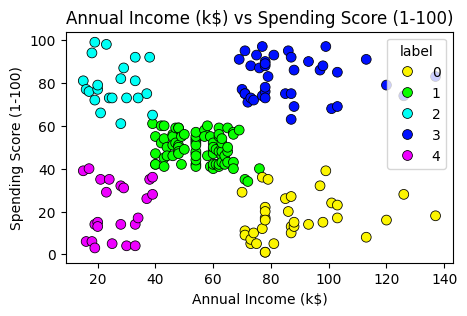

In [32]:
# Scatter plot with consistent color palette
plt.figure(figsize=(5, 3))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='label', data=df, palette=sns.color_palette("hsv", n_colors=5), s=50, edgecolor='k')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Annual Income (k$) vs Spending Score (1-100)')
plt.show()

In [33]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=814698ddaead39a265ae3c97575d919d315cea425360b7ec33f39c33ca3b37b7
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

## Pendefinisian Helper Functions

In [35]:
def cd(input_vector, weights):
    return np.linalg.norm(input_vector - weights, axis=2)

def fwuim(input_vector, weights):
    distances = cd(input_vector, weights)
    return np.unravel_index(np.argmin(distances), distances.shape)

def uw(input_vector, weights, winner, learning_rate, neighborhood_radius):
    distances = np.linalg.norm(np.indices(weights.shape[:2]).T - np.array(winner).reshape(1, -1), axis=2)
    influence = np.exp(-distances / (2 * neighborhood_radius**2))
    weights += learning_rate * influence[:, :, np.newaxis] * (input_vector - weights)

def train_som(image, num_epochs, initial_learning_rate, initial_neighborhood_radius):
    input_shape = image.shape
    som_shape = (10, 10, input_shape[2])
    weights = initialize_weights(input_shape, som_shape)

    for epoch in range(num_epochs):
        learning_rate = initial_learning_rate * np.exp(-epoch / num_epochs)
        neighborhood_radius = initial_neighborhood_radius * np.exp(-epoch / num_epochs)
        for i in range(input_shape[0]):
            for j in range(input_shape[1]):
                input_vector = image[i, j, :]
                winner = fwuim(input_vector, weights)
                uw(input_vector, weights, winner, learning_rate, neighborhood_radius)

    return weights

In [36]:
# inisialisasi bobot SOM
def initialize_weights(input_shape, output_shape):
    return np.random.rand(output_shape[0], output_shape[1], input_shape[2])

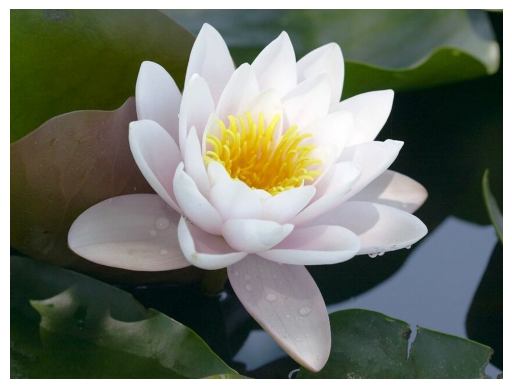

In [38]:
bunga = io.imread("bunga.jpg") / 255.0 # norm

plt.axis('off')
plt.imshow(bunga)

In [39]:
# Latih SOM
num_epochs = 10
initial_learning_rate = 0.1
initial_neighborhood_radius = 5
trained_weights = train_som(bunga, num_epochs, initial_learning_rate, initial_neighborhood_radius)

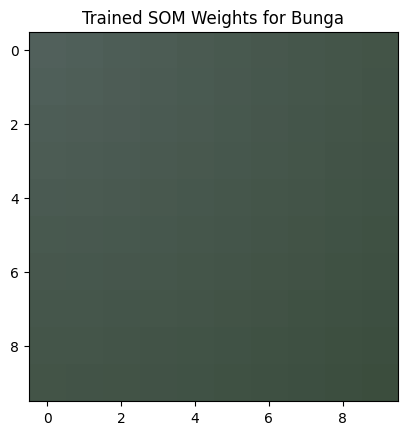

In [40]:
# Visualisasi bobot SOM
plt.imshow(trained_weights)
plt.title('Trained SOM Weights for Bunga')
plt.show()